In [147]:
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import math
import heapq
%matplotlib inline

In [148]:
# sep = "\\"  # вариант для Windows
sep = "/"  # вариат для Linux

Данная работа сравнивает поведение алгоритма A* с различными эвристиками на различных типах задач.
Задачи для тестирования взяты отсюда: `https://movingai.com/benchmarks/grids.html`. 

В данной работе у нас будет три карты (как и обычно, каждая карта - это некотрое прямоугольное поле из клеток, каждая клетка - либо свободна и в ней можно находиться, либо она занята препятствием) и для каждой карты будет по 100 задач (различной сложности! - эти задачи мы выбираем равномерно из сценариев для каждой из трёх карт (карты и сценарии к ним находятся по ссылке, показанной ранее)), которые тестируемые варианты алгоритма A* должны решить (каждая задача состоит из начальной клетки, из которой начинаем движение и конечной, в которую нам нужно найти кратчайший путь). Все карты предполагаются 8-связными (то есть из каждой клетки можно походить (если такой ход возможен) влево, вправо, вверх, вниз и 4 хода по диагонали). Ход в какую-то клетку возможен, если эта клетка не занята препятствием, а так же, если ход не срезает угол (то есть если мы ходим по диагонали, то эта диагональ не должна проходить через угол клетки, в которой есть препятствие).

Итак, для начала посмотрим на карты, которые выбраны для тестирования:


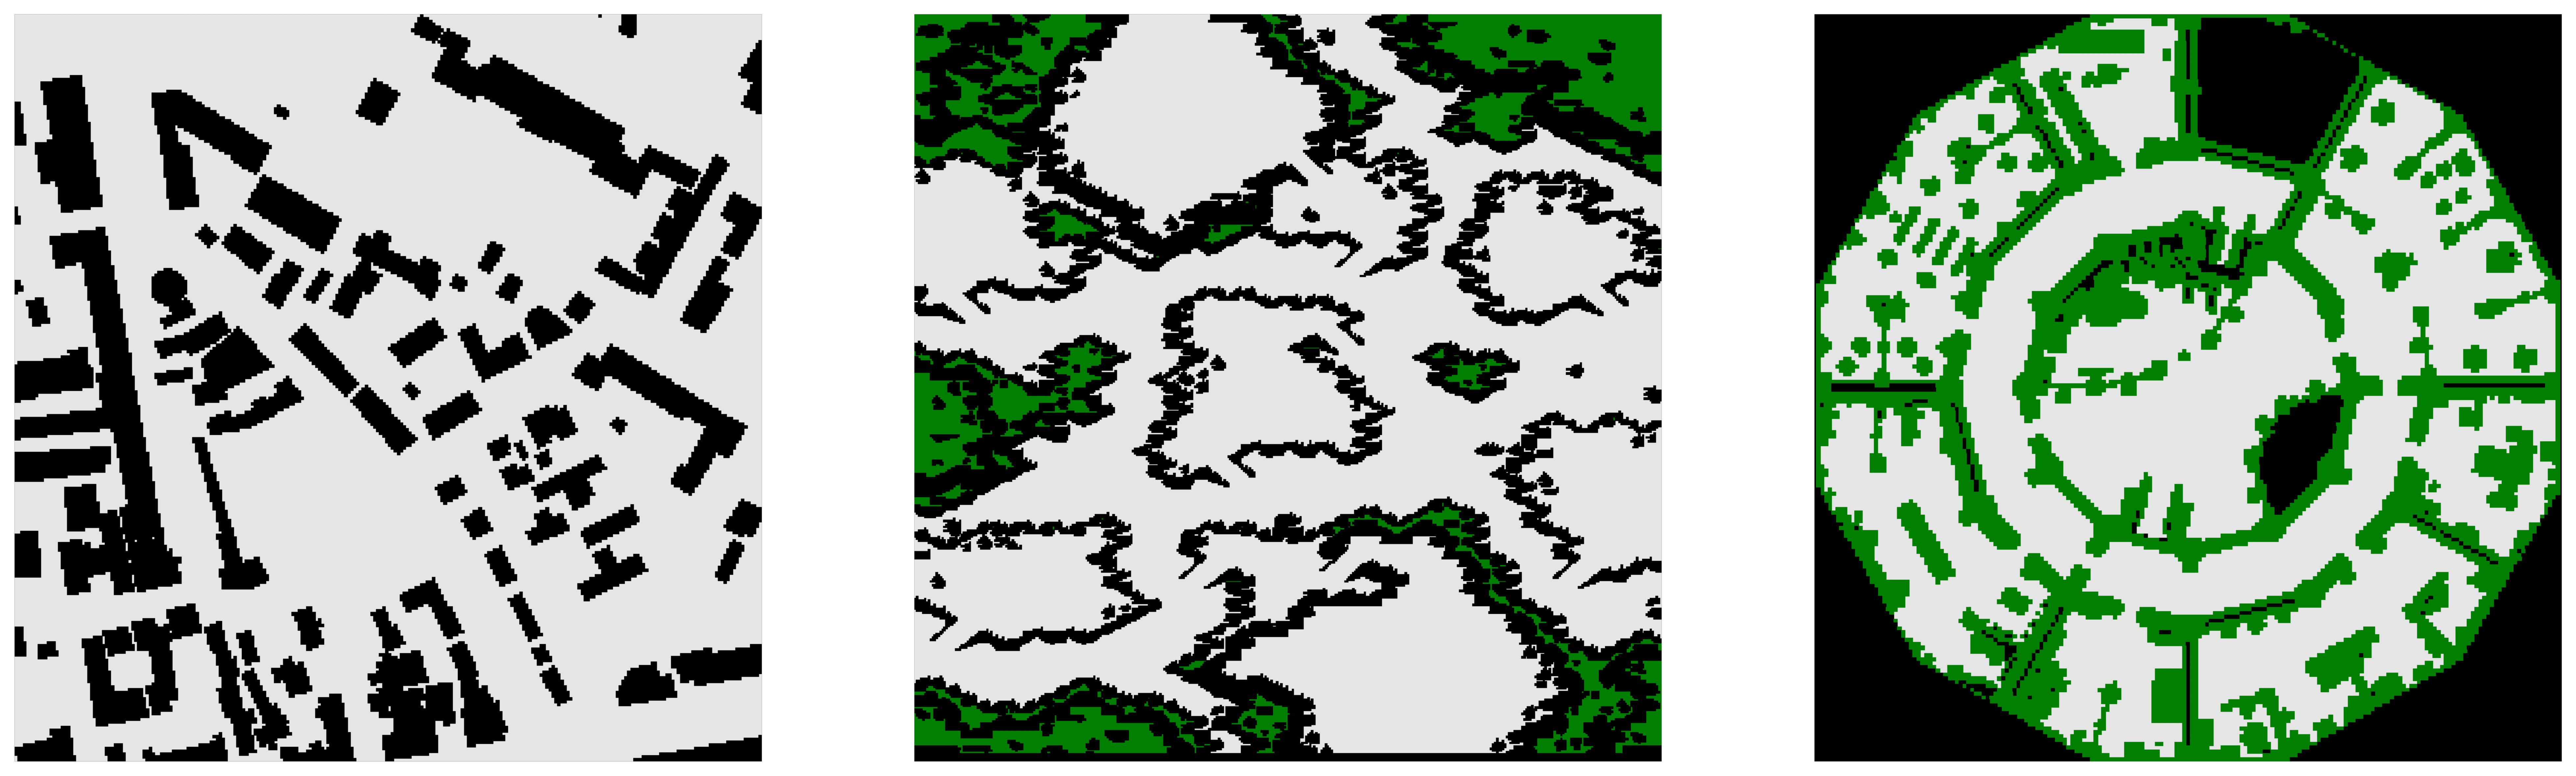

In [149]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 15), dpi=400)
ax[0].imshow(mpimg.imread(sep.join(["Москва", "Moscow_1_256.png"])))
ax[1].imshow(mpimg.imread(sep.join(["IceFloes из Starcraft", "IceFloes.png"])))
ax[2].imshow(mpimg.imread(sep.join(["lac304d из Dragon Age Origins", "lak304d.png"])))
for i in range(3): ax[i].axis("off")
plt.show()

Первая карта - городская - а именно, это карта части города Москва. Вторая карта - это карта IceFloes из игры Starcraft, она
интресна формой препятствий, которые образуют области, внутри которых можно находиться, но, чтобы их них выбраться, необходимо
найти выход из препятствий, которые как ограда окружают область. Третья карта - карта lac304d из игры Dragon Age: Origins, её 
форма напоминает круговой лабиринт - и чтобы дойти, например, от границы этого круга к его центру, нужно преодолеть множество
препятствий, образующих кольца вокруг центра.

Как можно заметить, все карты имеют совершенно разную топологию, благодаря чему наши тесты будут более объективными, а также
будут полезны не только для сравнения алгоритмов между собой, но и для сравнения эффективности одного алгоритма на разных картах.

В качестве вариантов алгоритма, которые мы будем тестировать, у нас будет A* без перераскрытий с четырьма различными эвристиками: евклидово расстояние, диагональная метрика, расстояние Чебышёва, манхэттенское расстояние. Последняя эвристика недопустима в случае 8-связной карты, но интересно посмотреть, насколько часто эта эвристика будет ошибаться (не находить кратчайший путь), и как эфективно будет работать.

То есть всего у нас три набора по 100 задач для каждого из 4 вариантов алгоритма A*.

Сразу покажем результаты тестирования в виде диаграмм и графиков. Ознакомиться же с процессом их получения, а так же с самим 
процессом тестирования можно будет далее в коде.

Во-первых, даиграмма, отражающая долю правильно решённых задач (то есть задач, где правильно найдена длина кратчайшего пути) каждым вариантом алгоритма A* среди всех задач данного набора:

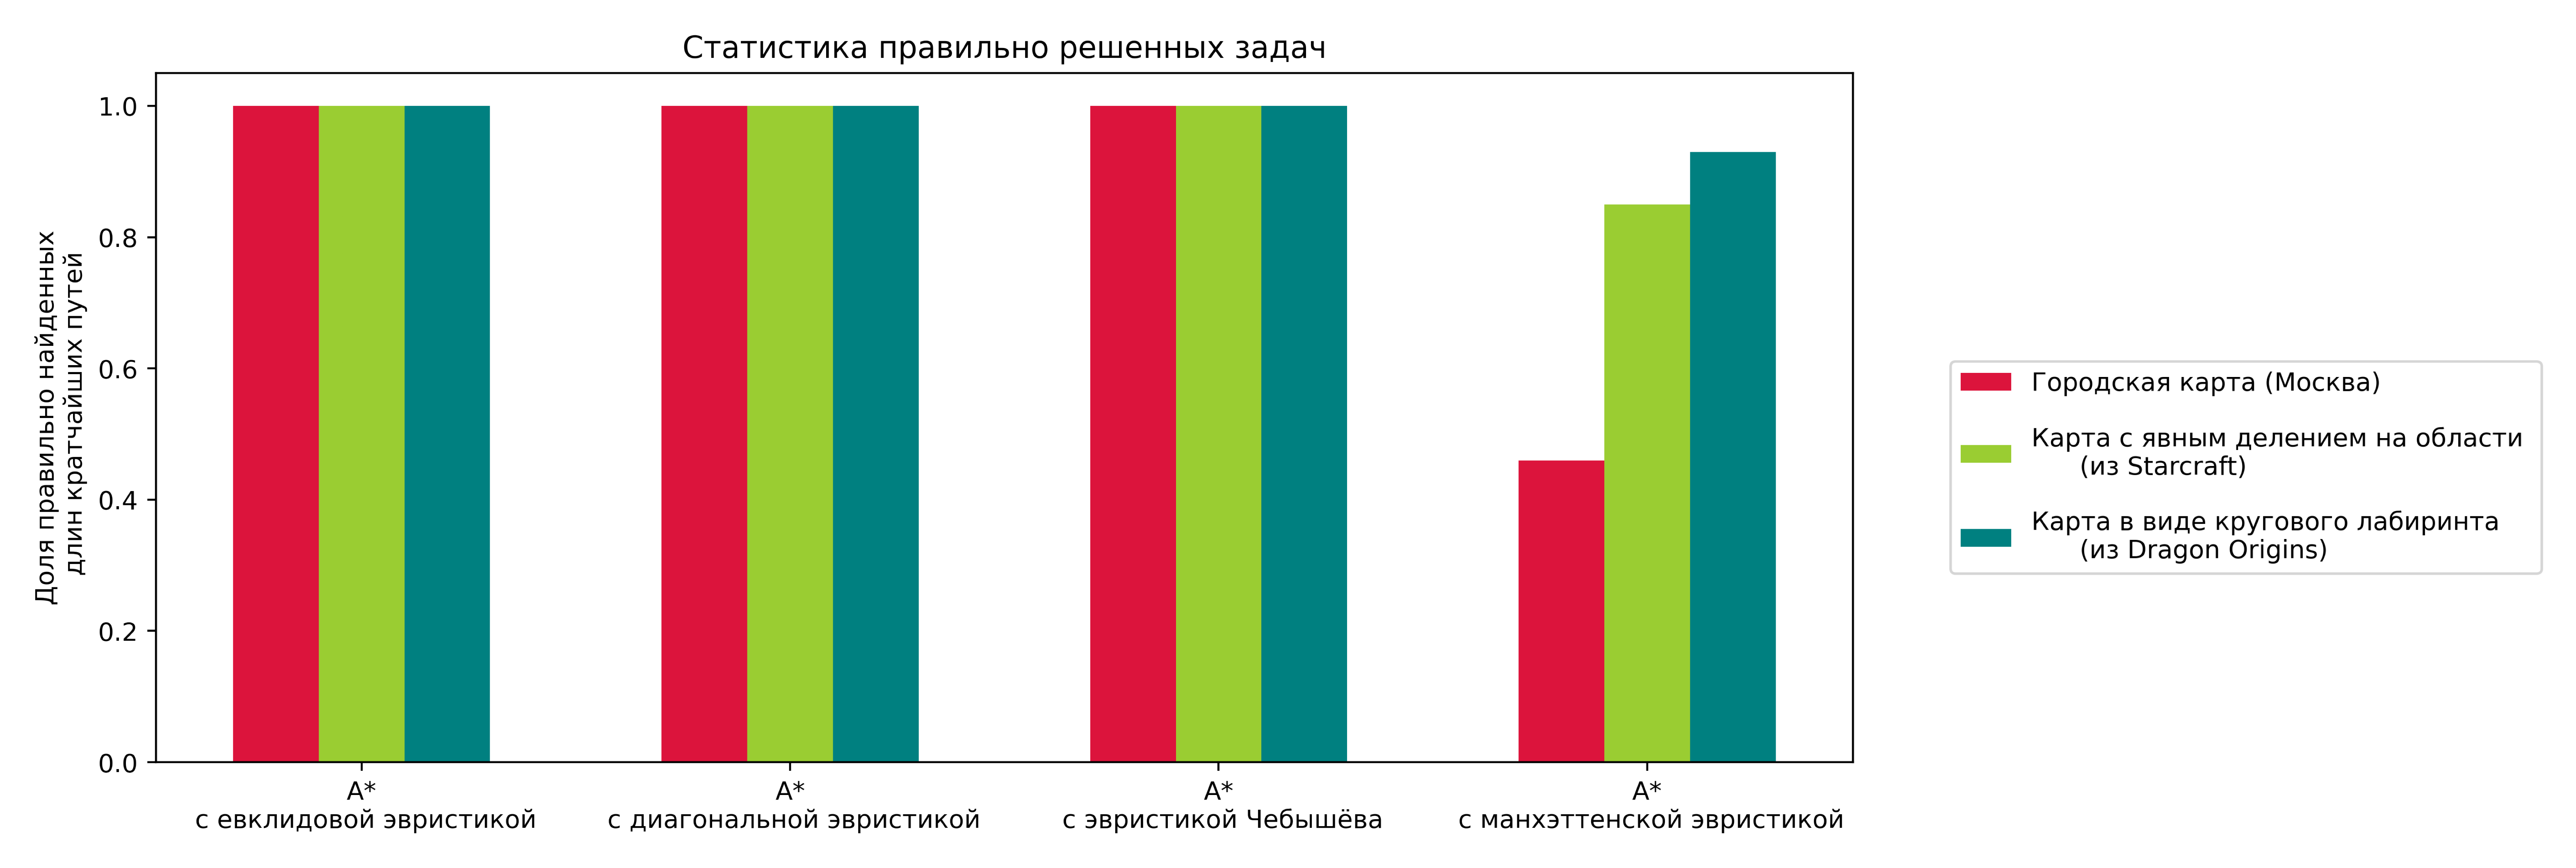

In [150]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "correct_ans.png"])))
plt.axis("off")
plt.show()

Как понятно из диаграммы, А* с евклидовой, диагональной и Чебышёвской эвристикой решают все задачи правильно, что ожидаемо, ведь все эти эвристики допустимые (то есть не переоценивают длину кратчайшего пути до целевой вершины). 

А вот манхэттенская эвристика, являясь недопустимой, в некоторых задачах приводит к неправильному ответу. Хуже всего эта эвристика справляется на городской карте (решает правильно около половины задач), что неудивительно, ведь эта карта довольно открытая, с длинными широкими и диагональнами (это мешает, ведь манхэттенское расстояние между двумя точками равно сумме катетов треугольника с вершинами в этих точках - и если есть диагональная улица, по которой проходит гипотенуза этого треугольника, то по этой улице можно добраться гораздо быстрее, чем предсказывает манхэттенское расстояние) улицами, а потому манхэттенское расстояние часто переоценивает кратчайший путь до целевой вершины. А вот на карте в виде кругового лабиринта переоценить расстояние сложно, ведь на ней много препятствий и часто, чтобы добраться от одной клетки до другой, необходимо преодалеть несколько круговых колец из препятствий, что по длительности гораздо больше манхэттенского расстояния, а раз данная эвристика нечасто переоценивает расстояние, то и кратчайший путь она часто находит верно.

Теперь посмотрим на статистику числа раскрытых вершин в ходе работы алгоритмов на каждой группе задач. Число раскрытых вершин, очевидно, равно количеству шагов алгоритма.

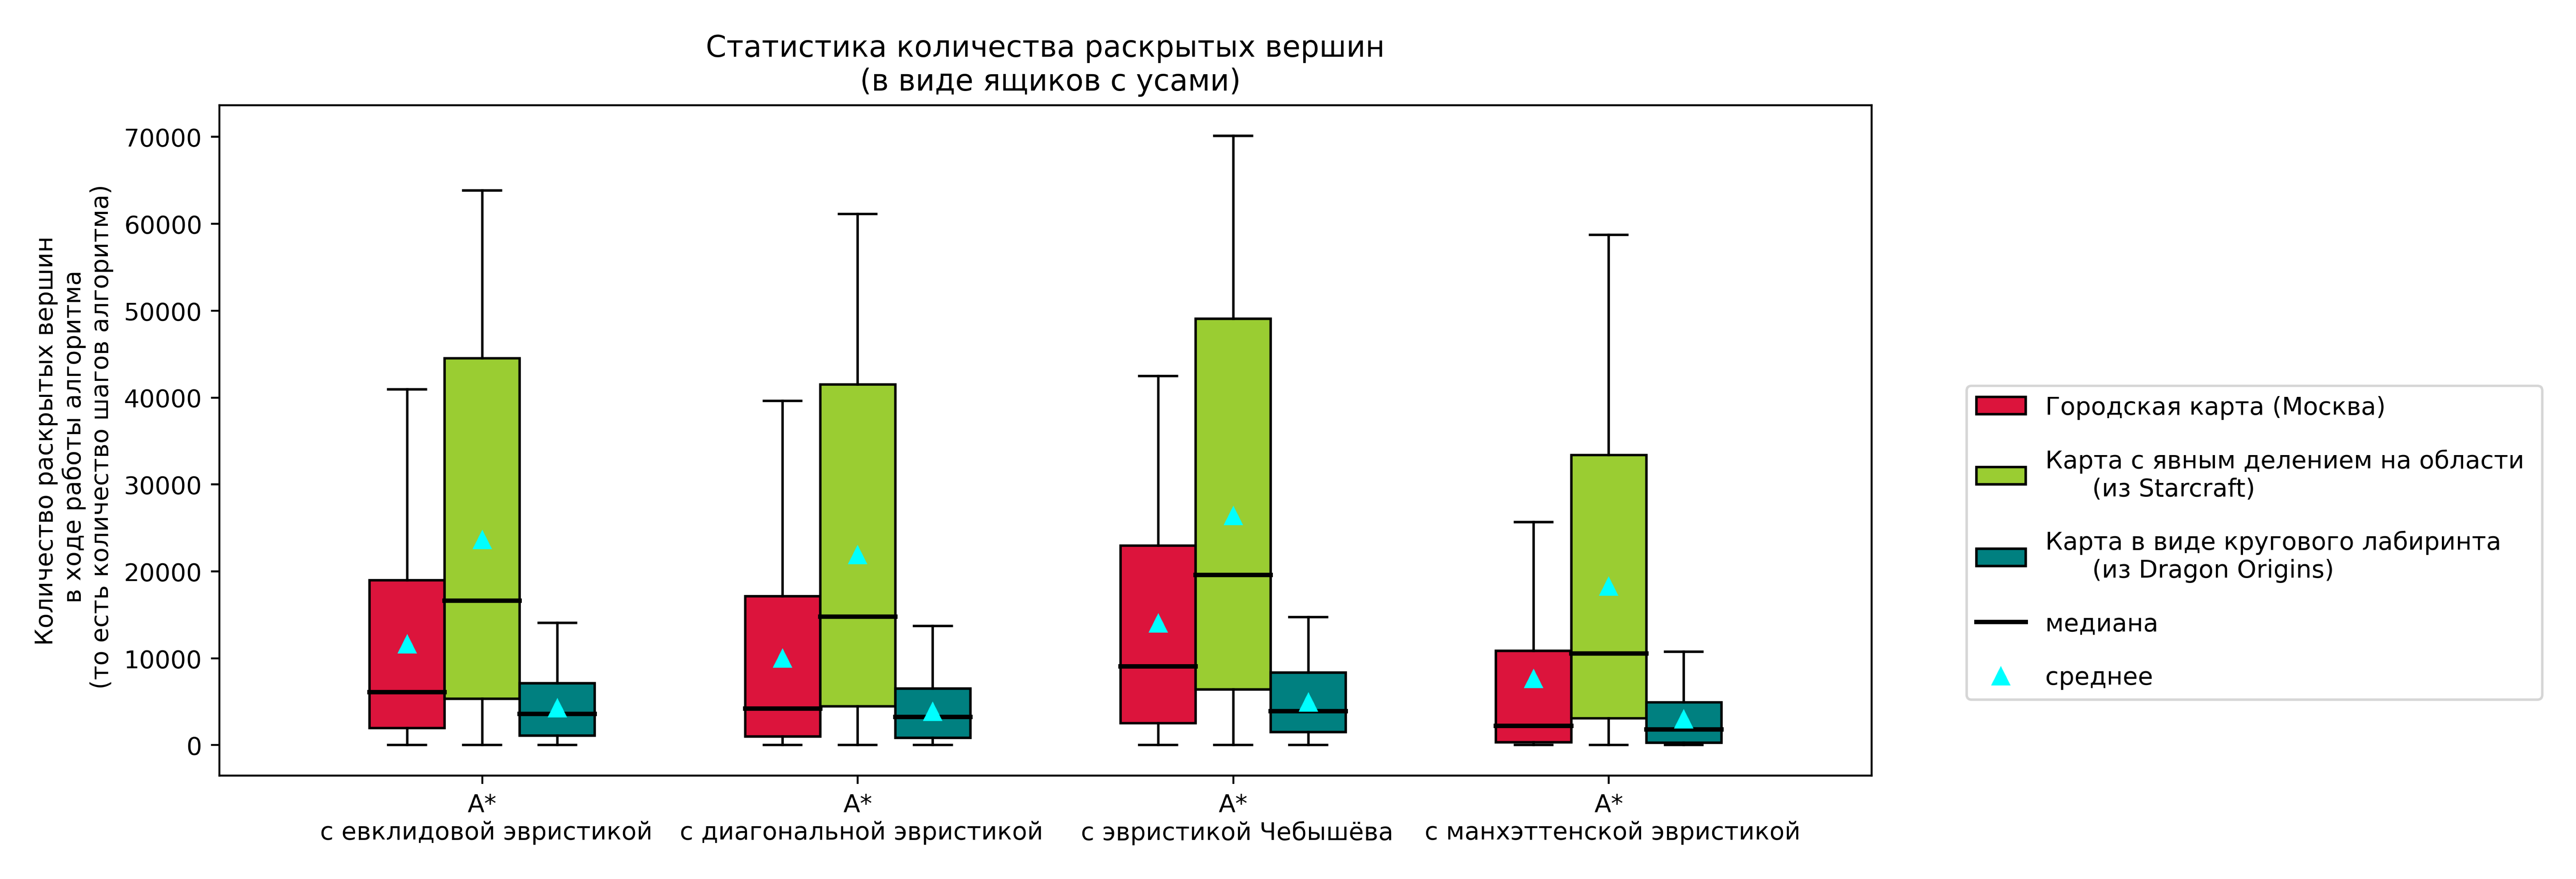

In [151]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "expanded_node.png"])))
plt.axis("off")
plt.show()

Среди состоятельных эвристик немного лучше остальных на всех наборах задач показывает себя диагональное расстояние - у него и
среднее число раскрытых вершин меньше, чем у остальных, и медиана меньше, и разброс значений меньше. В свою очередь 
манхэттенское расстояние показывает себя значительно лучше всех остальных эвристик по всем параметрам (медиана, разброс, 
среднее) на всех трёх наборах задач.

И напоследок посмотрим графики времени работы алгоритма в зависимости от сложности задачи. В качестве меры сложности задачи
будем брать просто истинную длину кратчайшего пути (чем больше, тем сложнее). Рассмотрим сразу два набора графиков - в одном время работы отложено на обычной шкале, а во втором время работы алгоритма будем откладывать на
логарифмической шкале (так будет нагляднее, ведь у нас время работы в зависимости от задачи может отличаться на несколько
порядков (от сотых долей секунды, до нескольких секунд)):

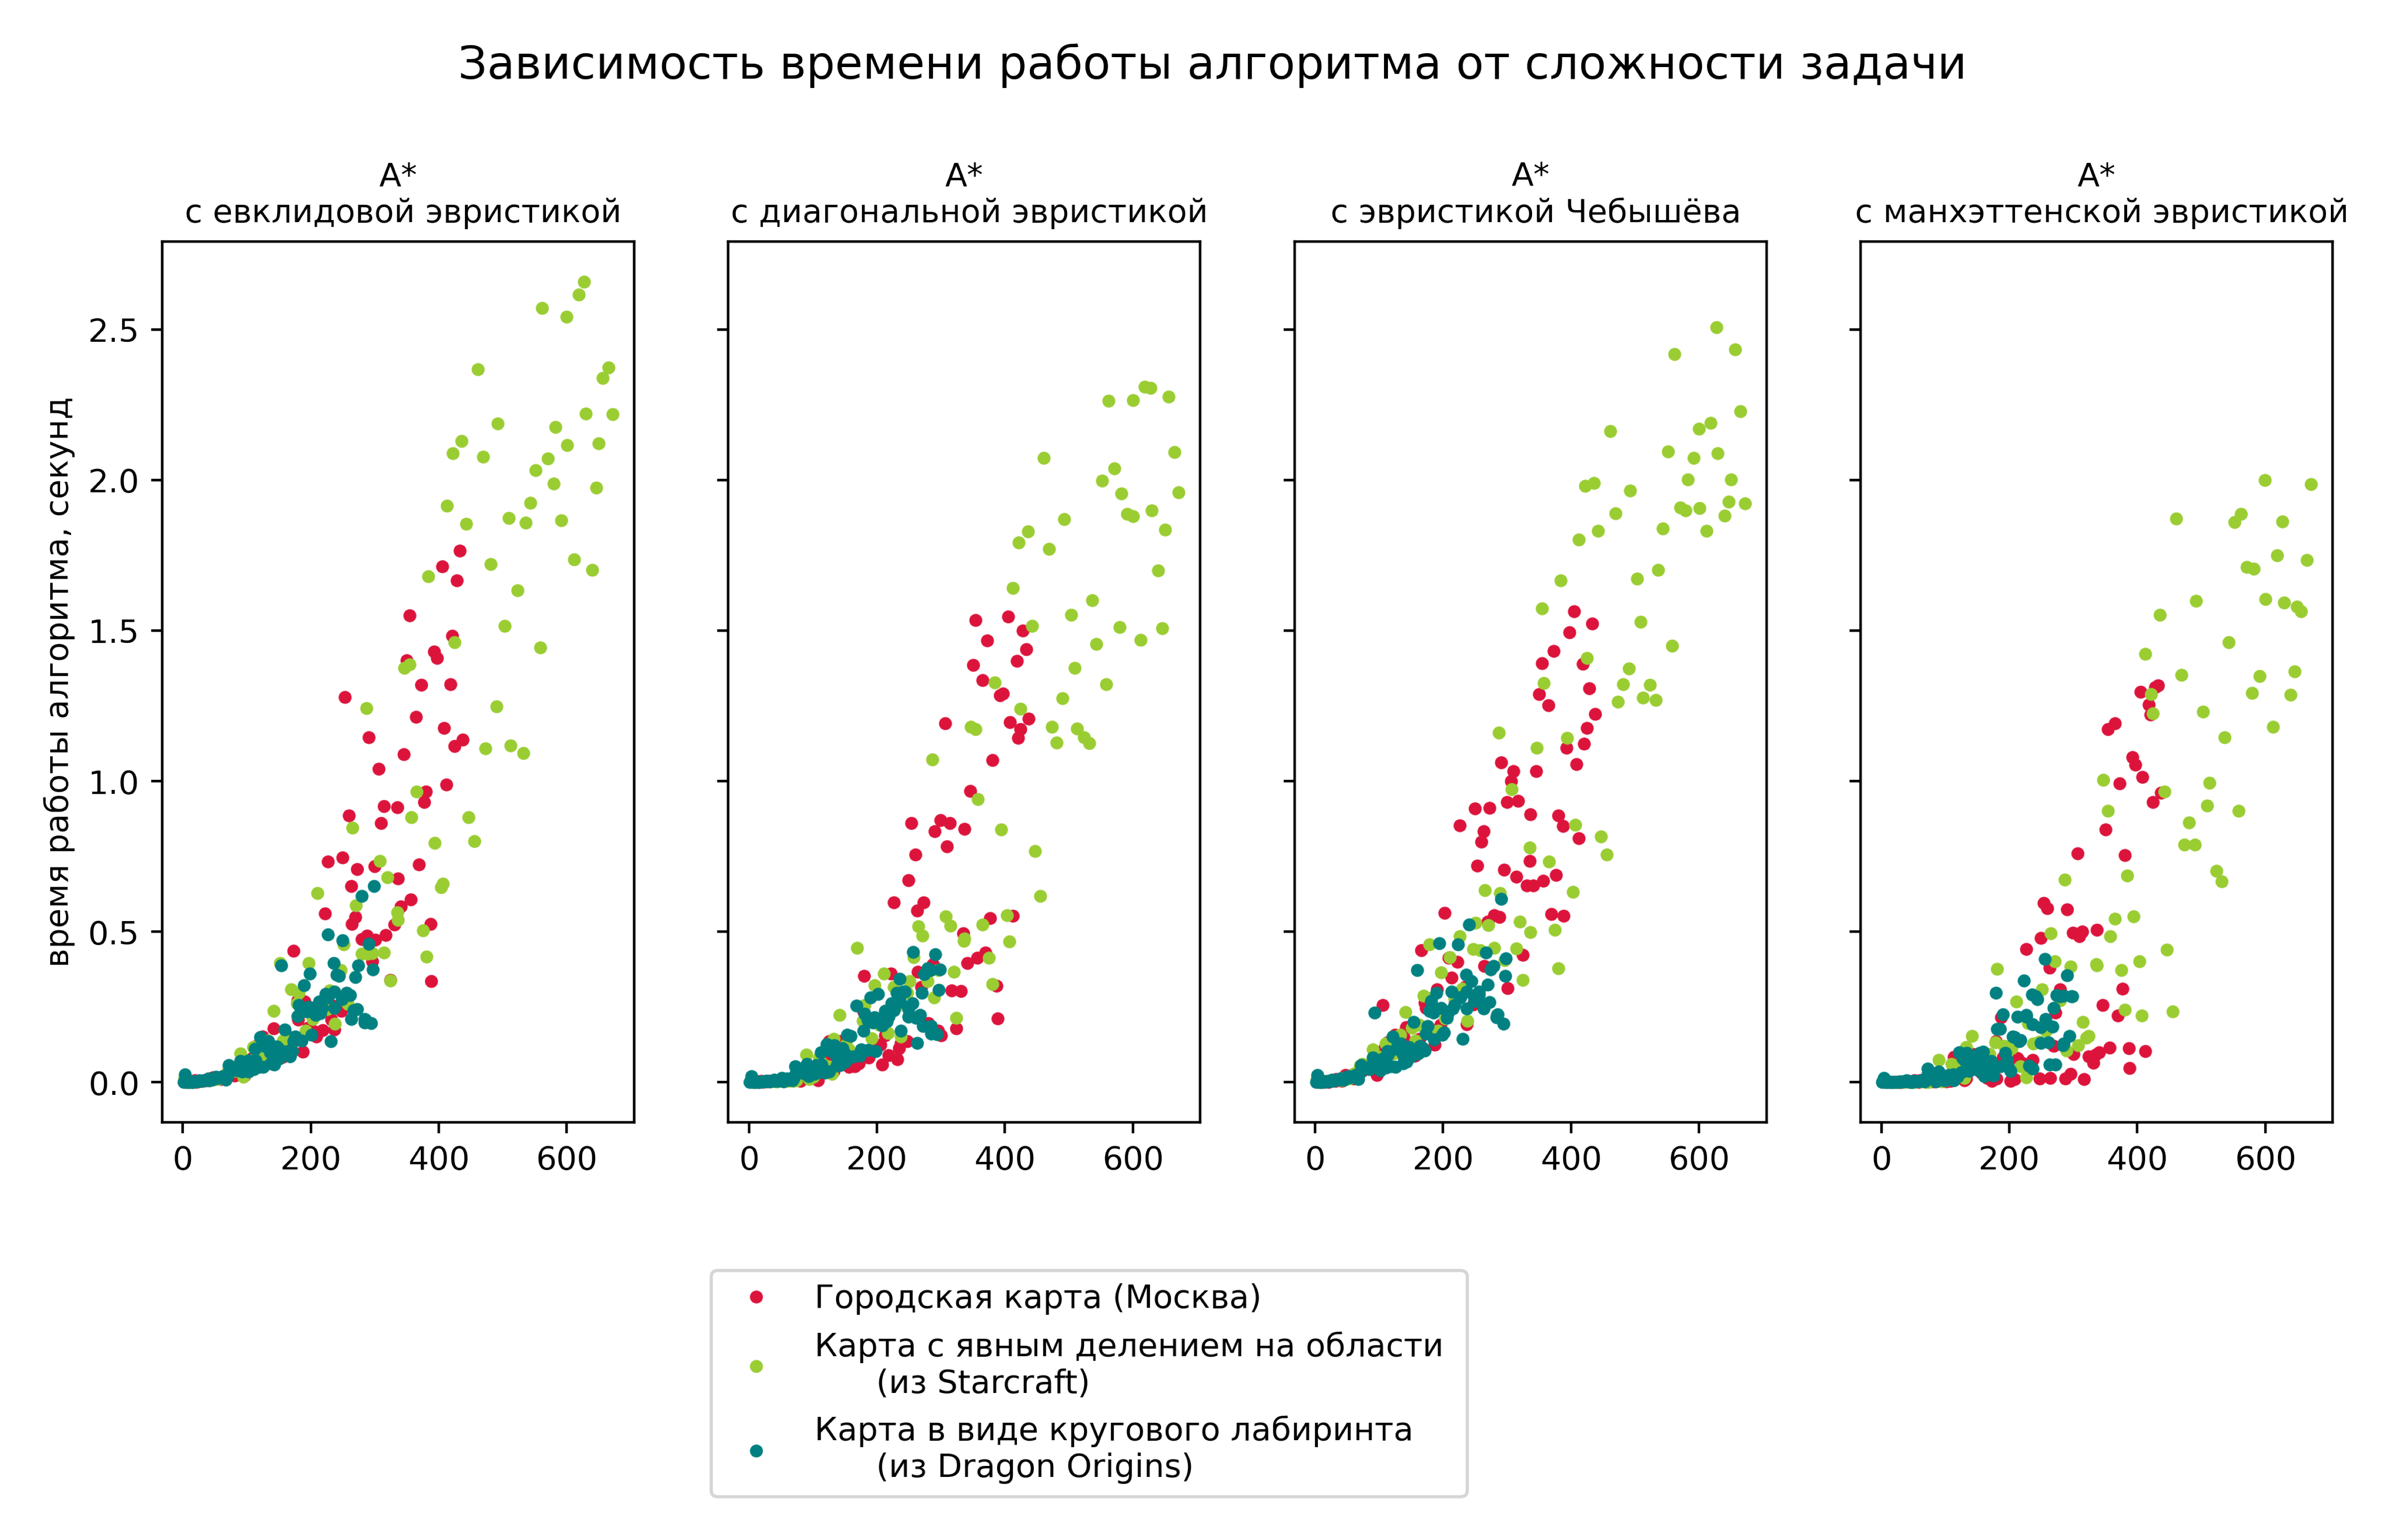

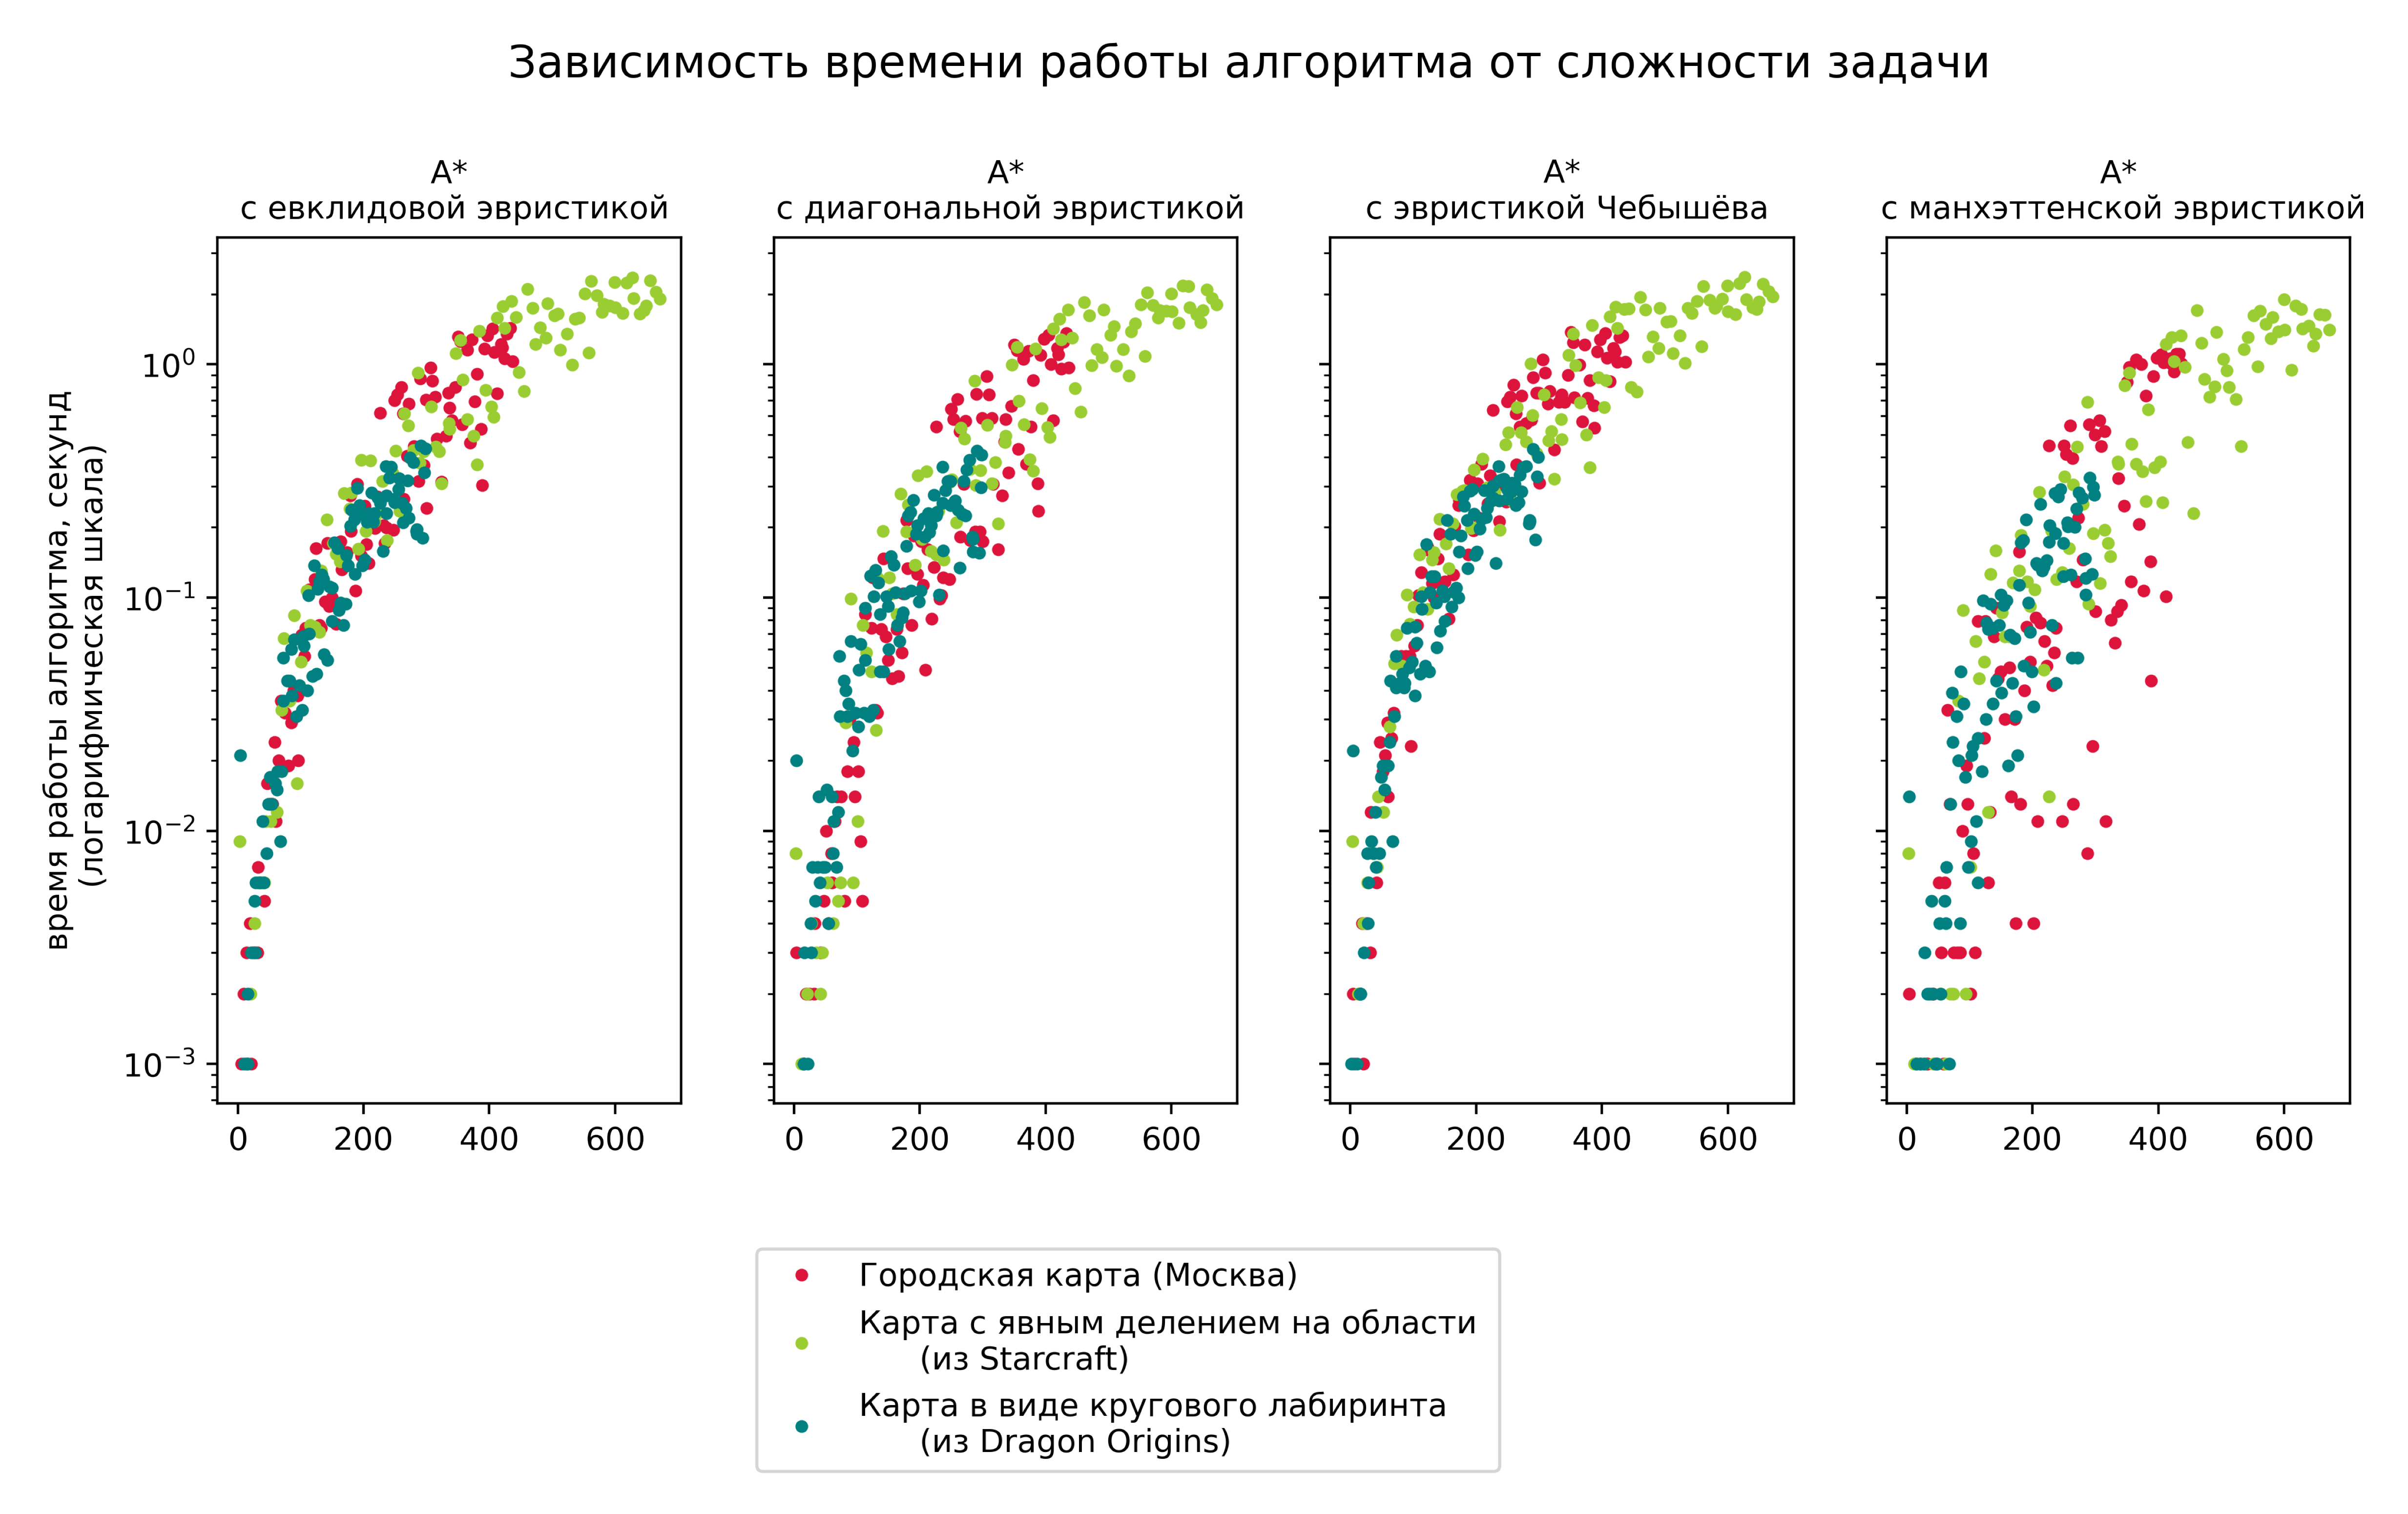

In [179]:
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "runtime.png"])))
plt.axis("off")
plt.show()
_, ax = plt.subplots(figsize=(20, 10), dpi=400)
plt.imshow(mpimg.imread(sep.join(["результаты", "runtime_log.png"])))
plt.axis("off")
plt.show()

Как понятно из графиков, все три состоятельные эвристики по времени работы сопоставимы (но иногда чуть-чуть лучше будет
диагональная эвристика), а вот манхэттенская эвристика на многих задачах, особенно на городской карте явно работает быстрее, 
чем состоятельные эвристики (правда на городских картах, как мы знаем, часто неправильно работает).

**Вывод**


Наиболее эффективной допустимой эвристикой для всех трёх типов задач оказалась диагональная эвристика.

Манхэттенское расстояние, хотя и недопустимая эвристика, но даёт заметное преимущество и по памяти (которая соответствует числу раскрытых вершин) и по времени для всех типов задач. Однако её уж точно не стоит использовать для открытых карт с длинными
проходами (такими как наша городская карта), так как доля ошибок на таких картах может быть больше половины. А вот для для
карт со сложной структорой, запутанными и часто меняющими направление проходами и далеко разнесенными начальной и целевой
точками, эту эвристику можно попробовать использовать, особенно в случае, когда нам не так сильно важна абсолютная точность, а когда мы готовы проехать путь возомжно чуть больший, зато потратить меньше ресурсов на его построение.

Далее уже идёт код.

-*-*--------------------------------------------------------------------------------------------------------------------------------------------------------------

In [153]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    
    def not_break_corner(self, curr_i, curr_j, destination_i, destination_j):  # функция, проверяющая, что переходом из (curr_i, curr_j) в (destination_i, destination_j) мы не срезаем углы.
        if abs(curr_i - destination_i) + abs(curr_j - destination_j) == 1:  # если это кардинальный ход (те вверх, вниз, вправо, влево), то никаких углов мы срезать не можем вообще, так как не ходим через угол
            return True
        else: # если ход по диагонали
            return (self.traversable(curr_i, destination_j)) and (self.traversable(destination_i, curr_j))  # выдаём, правда ли, что не срезаем углы
        # кстати, беспокоиться, что какая-то координата тут вне нашего поля - не нужно, ведь эту функцию мы возовем после проверки, что (destination_i, destination_j) лежит 
        # в поле и свободная - а тк сравнение в питоне ленивое, то если что-то из таких сравнений не выполнится, то этой функции питон не дойдёт
        

    def get_neighbors(self, i, j):
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]]  # наши 8 возможных смещений за один ход

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and self.not_break_corner(i, j, i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [154]:
def compute_cost(i1, j1, i2, j2):
    if abs(i1 - i2) + abs(j1 - j2) == 1: # если кардинальный ход, то его тоимость 1
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2:  # если диагональный ход, то его стоимость sqrt(2) - длина диагонли
        return math.sqrt(2)
    else:
        raise Exception('Поптыка посчитать стоимость недоступного хода. Возможны лишь кардинальные и диагональные ходы')

In [155]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return self.f < other.f

In [156]:
class SearchTreePQS:
    
    def __init__(self):
        self._open = []      
        self._closed = set()      
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    def open_is_empty(self):
        return len(self._open) == 0
     
    def add_to_open(self, item):  
        heapq.heappush(self._open, item)
        return
    
    def get_best_node_from_open(self):
        best = None
        while(True):
            best = heapq.heappop(self._open)  
            if (not self.was_expanded(best)): break
            if len(self._open) == 0: return None
        return best    

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

Далее определяем функции метрик, для которых будем тестировать алгоритм A*

In [157]:
def euclidean_distance(i1, j1, i2, j2):  # Евклидово расстояние
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

In [158]:
def octile_distance(i1, j1, i2, j2):  # Диагональная метрика
    delta_x = abs(i1 - i2)
    delta_y = abs(j1 - j2)
    return math.sqrt(2) * min(delta_x, delta_y) + abs(delta_x - delta_y)

In [159]:
def chebyshev_distance(i1, j1, i2, j2):  # Расстояние Чебышёва
    delta_x = abs(i1 - i2)
    delta_y = abs(j1 - j2)
    return max(delta_x, delta_y)

In [160]:
def manhattan_distance(i1, j1, i2, j2):  # Манхэттонское расстояние (недопустимая эвристика для 8-связного случая, но всё равно её протестируем, чтобы понять, насколько часты с ней будут ошибки (те не найдётся кратчайший путь))
    return abs(i1 - i2) + abs(j1 - j2)

Далее обычный алгоритм A*

In [161]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    ast = search_tree()
    steps = 0
    nodes_created = 0
    CLOSED = None

    start = Node(start_i, start_j, f = 0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    nodes_created += 1 
    ast.add_to_open(start)
        
    while (not ast.open_is_empty()):
        steps += 1
        
        curr_node = ast.get_best_node_from_open() 
        if curr_node is None: break
        ast.add_to_closed(curr_node)
        
        if ((curr_node.i == goal_i) and (curr_node.j == goal_j)):
            OPEN = ast.OPEN
            CLOSED = ast.CLOSED
            return (True, curr_node, steps, nodes_created, OPEN, CLOSED)
        
        for i, j in grid_map.get_neighbors(curr_node.i, curr_node.j):  
            transfer_cost = compute_cost(i1=curr_node.i, j1=curr_node.j, i2=i, j2=j) 
            succesor = Node(i=i, j=j, g=curr_node.g + transfer_cost, parent = curr_node, h=heuristic_func(i, j, goal_i, goal_j))
            nodes_created += 1
            
            if (not ast.was_expanded(item=succesor)):  
                ast.add_to_open(succesor)   

    CLOSED = ast.CLOSED
    return False, None, steps, nodes_created, None, CLOSED

Функции для чтения карты и сценариев:

In [162]:
def read_map_from_file(path):  # читаем карту из файла и возвращаем эту карту в виде объекста нашего класса Map
    map_file = open(path)
    _ = map_file.readline()
    height = int(map_file.readline().split()[1])
    width = int(map_file.readline().split()[1])
    _ = map_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    
    i = 0
    j = 0
    for line in map_file:
        j = 0
        for symbol in line:
            if symbol == '.' or symbol == 'G':
                cells[i][j] = 0
            else:
                cells[i][j] = 1
                
            j += 1
            if j == width: break
                
        i += 1
        if i == height: break
            
    map_file.close()
    read_map = Map()
    read_map.set_grid_cells(width, height, cells)
   
    return read_map

In [164]:
def read_scenarios_from_file(path, need_scenes):  # из файла равномерно читаем need_scenes сценариев
    scen_file = open(path)
    _ = scen_file.readline()
    
    scenarios = []
    for line in scen_file:
        columns = line.split("\t")[-5:]  # берём пять последних колонок (в них написаны координаты исходной точки, целевой точки и правильная длина кратчайшего пути)
        scenarios.append(list(map(int, columns[:-1])) + [float(columns[-1])])  # добавляем сценарий (те список из 5 чисел: координаты точек - целые (int) числа, а также длина пути - float число) в массив
    scen_file.close()
    
    num_all_scenes = len(scenarios)  # далее равномерное выбираем need_scenes сценариев из массива всех сценариев
    if num_all_scenes <= need_scenes: 
        complete_scenes = scenarios
    elif need_scenes == 1:
        complete_scenes = [scenarios[0]]
    else:
        step = (num_all_scenes - 1) / (need_scenes - 1)
        complete_scenes = []
        for i in range(need_scenes):
            complete_scenes.append(scenarios[round(step * i)])
            
    return complete_scenes
    

Вводим предварительные данные для тестирования

In [165]:
n = 100  # число сценариев для каждой карты
eps = 1e-5  # число, на сколько могут отличаться float значения, чтобы мы считали их равными (это для сравнений длин кратчайших путей)

In [166]:
import time  # чтобы мерить время работы программы

In [167]:
# Три карты и по n=100 сценариев для каждой из них - на этих 300 задачах и будем тестировать наш алгоритм A* для каждой метрики
num_maps = 3  # число карт

moscow_map = read_map_from_file(sep.join(["Москва", "Moscow_1_256.map"]))  # считываем карту
moscow_scenes = read_scenarios_from_file(sep.join(["Москва", "Moscow_1_256.map.scen"]), n)  # и n сценариев к ней

icefloes_map = read_map_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map"]))
icefloes_scenes = read_scenarios_from_file(sep.join(["IceFloes из Starcraft", "IceFloes.map.scen"]), n)

dragon_map = read_map_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map"]))
dragon_scenes = read_scenarios_from_file(sep.join(["lac304d из Dragon Age Origins", "lak304d.map.scen"]), n)

tests_map = [moscow_map, icefloes_map, dragon_map]  # собираем все в массив
tests_scene = [moscow_scenes, icefloes_scenes, dragon_scenes]

In [168]:
# Для каждой из 4 метрик (которые будут использоваться в качестве эвристических функций), 
# для которых будем тестировать наш алгоитм A*, вводим по три массива - в каждом будут лежать результаты теста  алгоритма A*
# с этой метрикой на каждой из 300 задач

# первый массив содержит 1 и 0 (1, если задача решена правильно (кратчайший путь найден верно) и 0 иначе)
# второй массив содержит чило раскрытых вершин на каждой задаче
# третий массив содержит время работы алгоритма на задаче

# но так как у нас не один набор задач, а num_maps наборов - те для каждой карты свой набор из n задач,
# то у нас каждый из трёх массивов - это набор из num_maps массивов, в каждом из которых уже лежат числа, описанные выше
# (1 и 0 для массивов в correct_ans, число раскрытий в number_of_expansions, время работы в массивых из runtime) - каждый из
# num_maps массивов содержит по n чисел - по одному для каждой задачи из соответсвующего набора (те для соответствующей карты)

eucl_correct_ans = [[] for _ in range(num_maps)]
eucl_number_of_expansions = [[] for _ in range(num_maps)]
eucl_runtime = [[] for _ in range(num_maps)]

octile_correct_ans = [[] for _ in range(num_maps)]
octile_number_of_expansions = [[] for _ in range(num_maps)]
octile_runtime = [[] for _ in range(num_maps)]

cheb_correct_ans = [[] for _ in range(num_maps)]
cheb_number_of_expansions = [[] for _ in range(num_maps)]
cheb_runtime = [[] for _ in range(num_maps)]

manh_correct_ans = [[] for _ in range(num_maps)]
manh_number_of_expansions = [[] for _ in range(num_maps)]
manh_runtime = [[] for _ in range(num_maps)]

In [169]:
# собираем всё для каждой метрики в массив
metrics = [euclidean_distance, octile_distance, chebyshev_distance, manhattan_distance]
correct_ans = [eucl_correct_ans, octile_correct_ans, cheb_correct_ans, manh_correct_ans]
number_of_expansions = [eucl_number_of_expansions, octile_number_of_expansions, 
                        cheb_number_of_expansions, manh_number_of_expansions]
runtime = [eucl_runtime, octile_runtime, cheb_runtime, manh_runtime]

Наконец начинаем тестировать:

In [170]:
for metric, corr_ans, num_exp, rt in zip(metrics, correct_ans, number_of_expansions, runtime):
    for test_map, test_scene, num_map in zip(tests_map, tests_scene, range(num_maps)):
        for scene in test_scene:
            start_j = scene[0]  # ВАЖНО!!! у нас i - это координата по выосте (те номер строки), а j - координата по горизонтали!
            start_i = scene[1]  # а в сценарии первой идёт координата x (координата по горизонтали), а потом y (по вертикали)
            goal_j = scene[2]  # поэтому читаем только так! - сначала j координата (start_j), затем i (start_i)
            goal_i = scene[3]  # на этом была долго ошибка, которую сложно было найти...
            
            true_length_of_path = scene[4]  # настоящая длина кратчайшего пути, с которой нам нужно сверить

            begin_time = time.time()
            find_path, last_node, num_steps, _, _, _ = astar(test_map, start_i, start_j, goal_i, 
                                                             goal_j, heuristic_func=metric, 
                                                             search_tree=SearchTreePQS)  # берём три нужных нам результата работы алгоритма
            time_for_astar = time.time() - begin_time

            if find_path:  # если путь алгоритм нашёл
                corr_ans[num_map].append(int(abs(last_node.g - true_length_of_path) < eps))
                num_exp[num_map].append(num_steps)
                rt[num_map].append(round(time_for_astar, 3))
            else:
                raise Exception("Что-то не так")  # если путь н нашли, то выдаём исключение, ведь во всех наших тестах путь точно есть 

In [171]:
# можно вывести массивы...
"""print("ЕВКЛИД")
print("корректность: ", eucl_correct_ans)
print("раскрытий: ", eucl_number_of_expansions)
print("время: ", eucl_runtime)
print()
print()

print("ДИАГОНАЛЬНАЯ")
print("корректность: ", octile_correct_ans)
print("раскрытий: ", octile_number_of_expansions)
print("время: ", octile_runtime)
print()
print()

print("ЧЕБЫШЕВ")
print("корректность: ", cheb_correct_ans)
print("раскрытий: ", cheb_number_of_expansions)
print("время: ", cheb_runtime)
print()
print()

print("МАНХЭТТЕН")
print("корректность: ", manh_correct_ans)
print("раскрытий: ", manh_number_of_expansions)
print("время: ", manh_runtime)"""

'print("ЕВКЛИД")\nprint("корректность: ", eucl_correct_ans)\nprint("раскрытий: ", eucl_number_of_expansions)\nprint("время: ", eucl_runtime)\nprint()\nprint()\n\nprint("ДИАГОНАЛЬНАЯ")\nprint("корректность: ", octile_correct_ans)\nprint("раскрытий: ", octile_number_of_expansions)\nprint("время: ", octile_runtime)\nprint()\nprint()\n\nprint("ЧЕБЫШЕВ")\nprint("корректность: ", cheb_correct_ans)\nprint("раскрытий: ", cheb_number_of_expansions)\nprint("время: ", cheb_runtime)\nprint()\nprint()\n\nprint("МАНХЭТТЕН")\nprint("корректность: ", manh_correct_ans)\nprint("раскрытий: ", manh_number_of_expansions)\nprint("время: ", manh_runtime)'

Теперь отобразим результаты в симпатичном виде

In [172]:
# но для начала для удобства все наши массивы переделаем в numpy
eucl_correct_ans = np.array(eucl_correct_ans)
eucl_number_of_expansions = np.array(eucl_number_of_expansions)
eucl_runtime = np.array(eucl_runtime)

octile_correct_ans = np.array(octile_correct_ans)
octile_number_of_expansions = np.array(octile_number_of_expansions)
octile_runtime = np.array(octile_runtime)

cheb_correct_ans = np.array(cheb_correct_ans)
cheb_number_of_expansions = np.array(cheb_number_of_expansions)
cheb_runtime = np.array(cheb_runtime)

manh_correct_ans = np.array(manh_correct_ans)
manh_number_of_expansions = np.array(manh_number_of_expansions)
manh_runtime = np.array(manh_runtime)

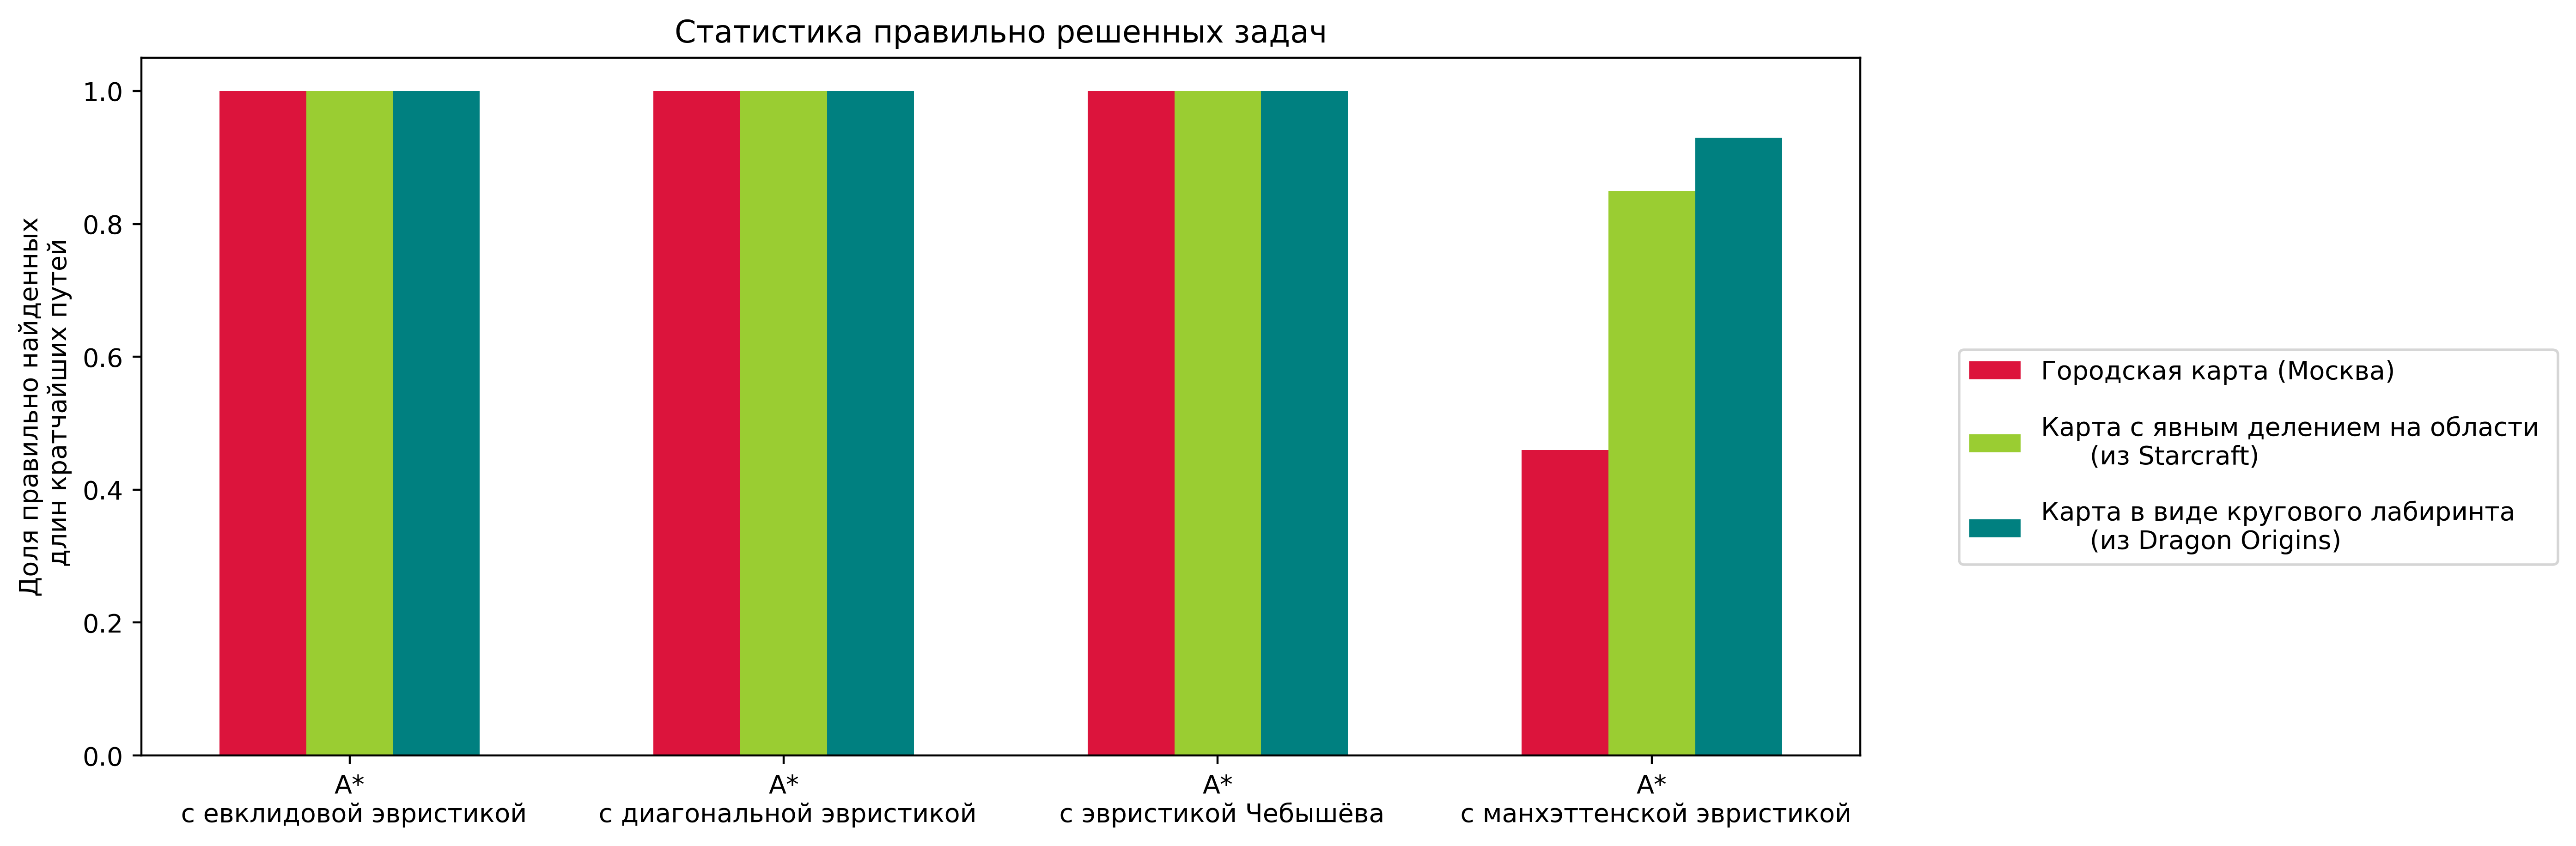

In [173]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Статистика правильно решенных задач")
ax.set_ylabel("Доля правильно найденных\n длин кратчайших путей")

index = np.arange(4)
shift = 0.2
width_of_bar = np.ones(4) * 0.2

values = np.hstack((eucl_correct_ans.mean(axis=1).reshape(-1, 1),
                   octile_correct_ans.mean(axis=1).reshape(-1, 1), 
                   cheb_correct_ans.mean(axis=1).reshape(-1, 1), 
                   manh_correct_ans.mean(axis=1).reshape(-1, 1)))

plt.bar(index, values[0], color="crimson", width=width_of_bar, label="Городская карта (Москва)")
plt.bar(index + shift, values[1], color="yellowgreen", width=width_of_bar, label="Карта с явным делением на области \n      (из Starcraft)")

plt.bar(index + 2 * shift, values[2], color="teal", width=width_of_bar, label="Карта в виде кругового лабиринта \n      (из Dragon Origins)")
plt.xticks(index + shift, ['A*\n с евклидовой эвристикой','A*\n с диагональной эвристикой','A*\n с эвристикой Чебышёва','A*\n с манхэттенской эвристикой'])
plt.legend(bbox_to_anchor = (1.05, 0.6), labelspacing=1.2)
plt.show()

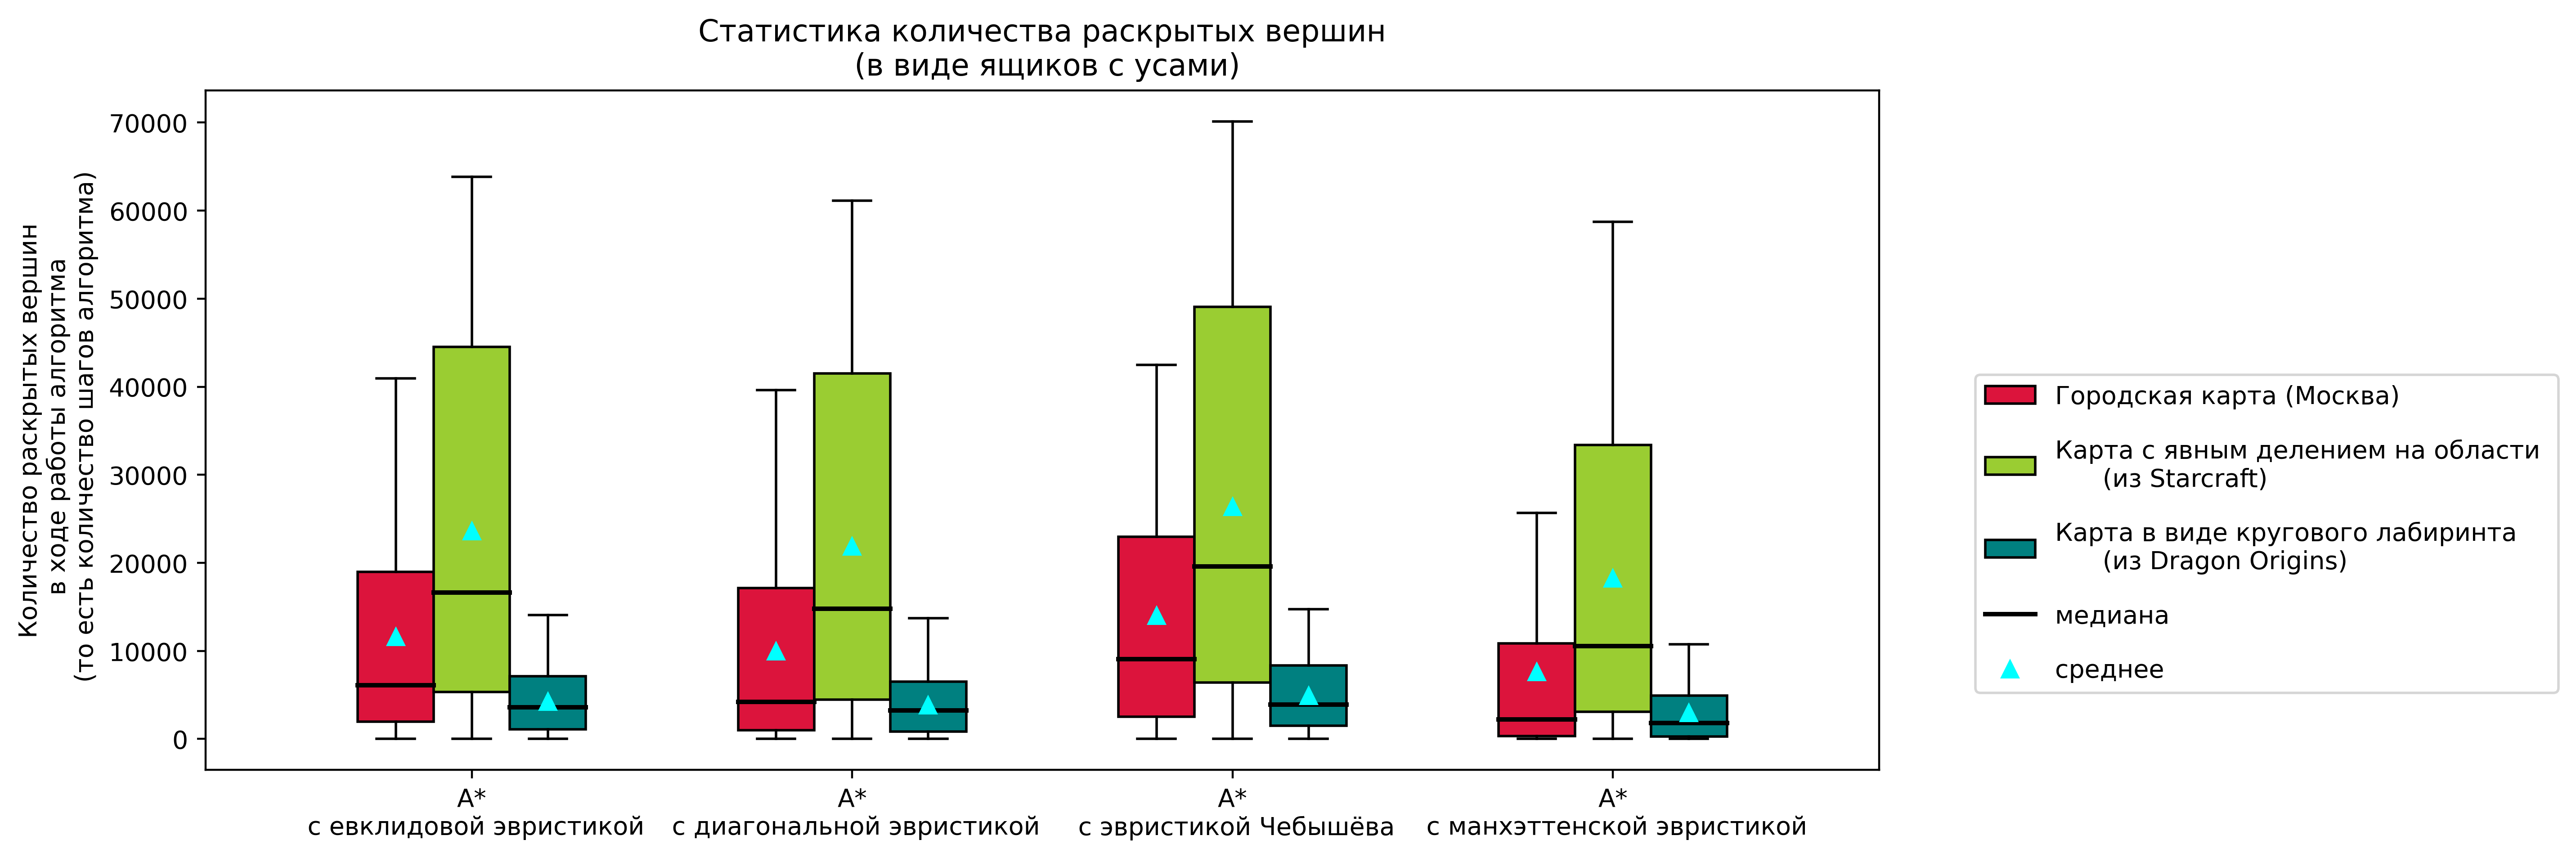

In [174]:
_, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.set_title("Статистика количества раскрытых вершин\n (в виде ящиков с усами)")
ax.set_ylabel("Количество раскрытых вершин\n в ходе работы алгоритма\n (то есть количество шагов алгоритма)")

shift = 0.2
index = np.arange(4)

boxes1 = plt.boxplot((eucl_number_of_expansions[0], 
             octile_number_of_expansions[0], 
             cheb_number_of_expansions[0], 
             manh_number_of_expansions[0]), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="crimson"),  # patch_artist=True - обязательно, чтобы могли задавать пользовательские цвета
            widths=shift, positions=index, showfliers=False,  # showfliers=False - выбросы не показываем (их не много), positions=index - расставляем ящики по позициям
            medianprops=dict(linewidth=1.8, color="black"),  # черту медианы настраиваем
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))  # среднее значение настраиваем

boxes2 = plt.boxplot((eucl_number_of_expansions[1], 
             octile_number_of_expansions[1], 
             cheb_number_of_expansions[1], 
             manh_number_of_expansions[1]), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="yellowgreen"), 
            widths=shift, positions=index + shift, showfliers=False,  # positions=index + shift - сдвигаем следующие ящики
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))

boxes3 = plt.boxplot((eucl_number_of_expansions[2], 
             octile_number_of_expansions[2], 
             cheb_number_of_expansions[2], 
             manh_number_of_expansions[2]), 
            showmeans=True, patch_artist=True, boxprops=dict(facecolor="teal"), 
            widths=shift, positions=index + 2 * shift, showfliers=False,
            medianprops=dict(linewidth=1.8, color="black"),
            meanprops=dict(markeredgewidth=0, markerfacecolor="cyan", markersize=8))


plt.xticks(index + shift, ['A*\n с евклидовой эвристикой','A*\n с диагональной эвристикой','A*\n с эвристикой Чебышёва','A*\n с манхэттенской эвристикой'])
plt.legend([boxes1["boxes"][0], boxes2["boxes"][0], boxes3["boxes"][0], boxes1["medians"][0], boxes1["means"][0]],
           ["Городская карта (Москва)", "Карта с явным делением на области \n      (из Starcraft)", 
            "Карта в виде кругового лабиринта \n      (из Dragon Origins)", "медиана", "среднее"], # так сложно настраиваем легенду, ведь у нас по 
           # 4 ящика каждого типа (у нас отличаются цветом) (и 12 медиан и средних) - поэтому если явно указать параметр label="город" в boxprops 
           # при отрисовке boxplot, у нас в легенде для каждого цвета будет по 4 раза написана одна и та же строка легенды (то, что такой-то 
           # цвет - это город - вот таких строчек будет по 4 для каждого цвета (ведь каждого цвета у нас 4 ящика))
           bbox_to_anchor = (1.05, 0.6), labelspacing=1.2)  # этим настраиваем положение легенды вне графика и расстояние между строками легенды
plt.show()

In [175]:
moscow_hardness = np.array(moscow_scenes)[:, 4]
icefloes_hardness = np.array(icefloes_scenes)[:, 4]
dragon_hardness = np.array(dragon_scenes)[:, 4]

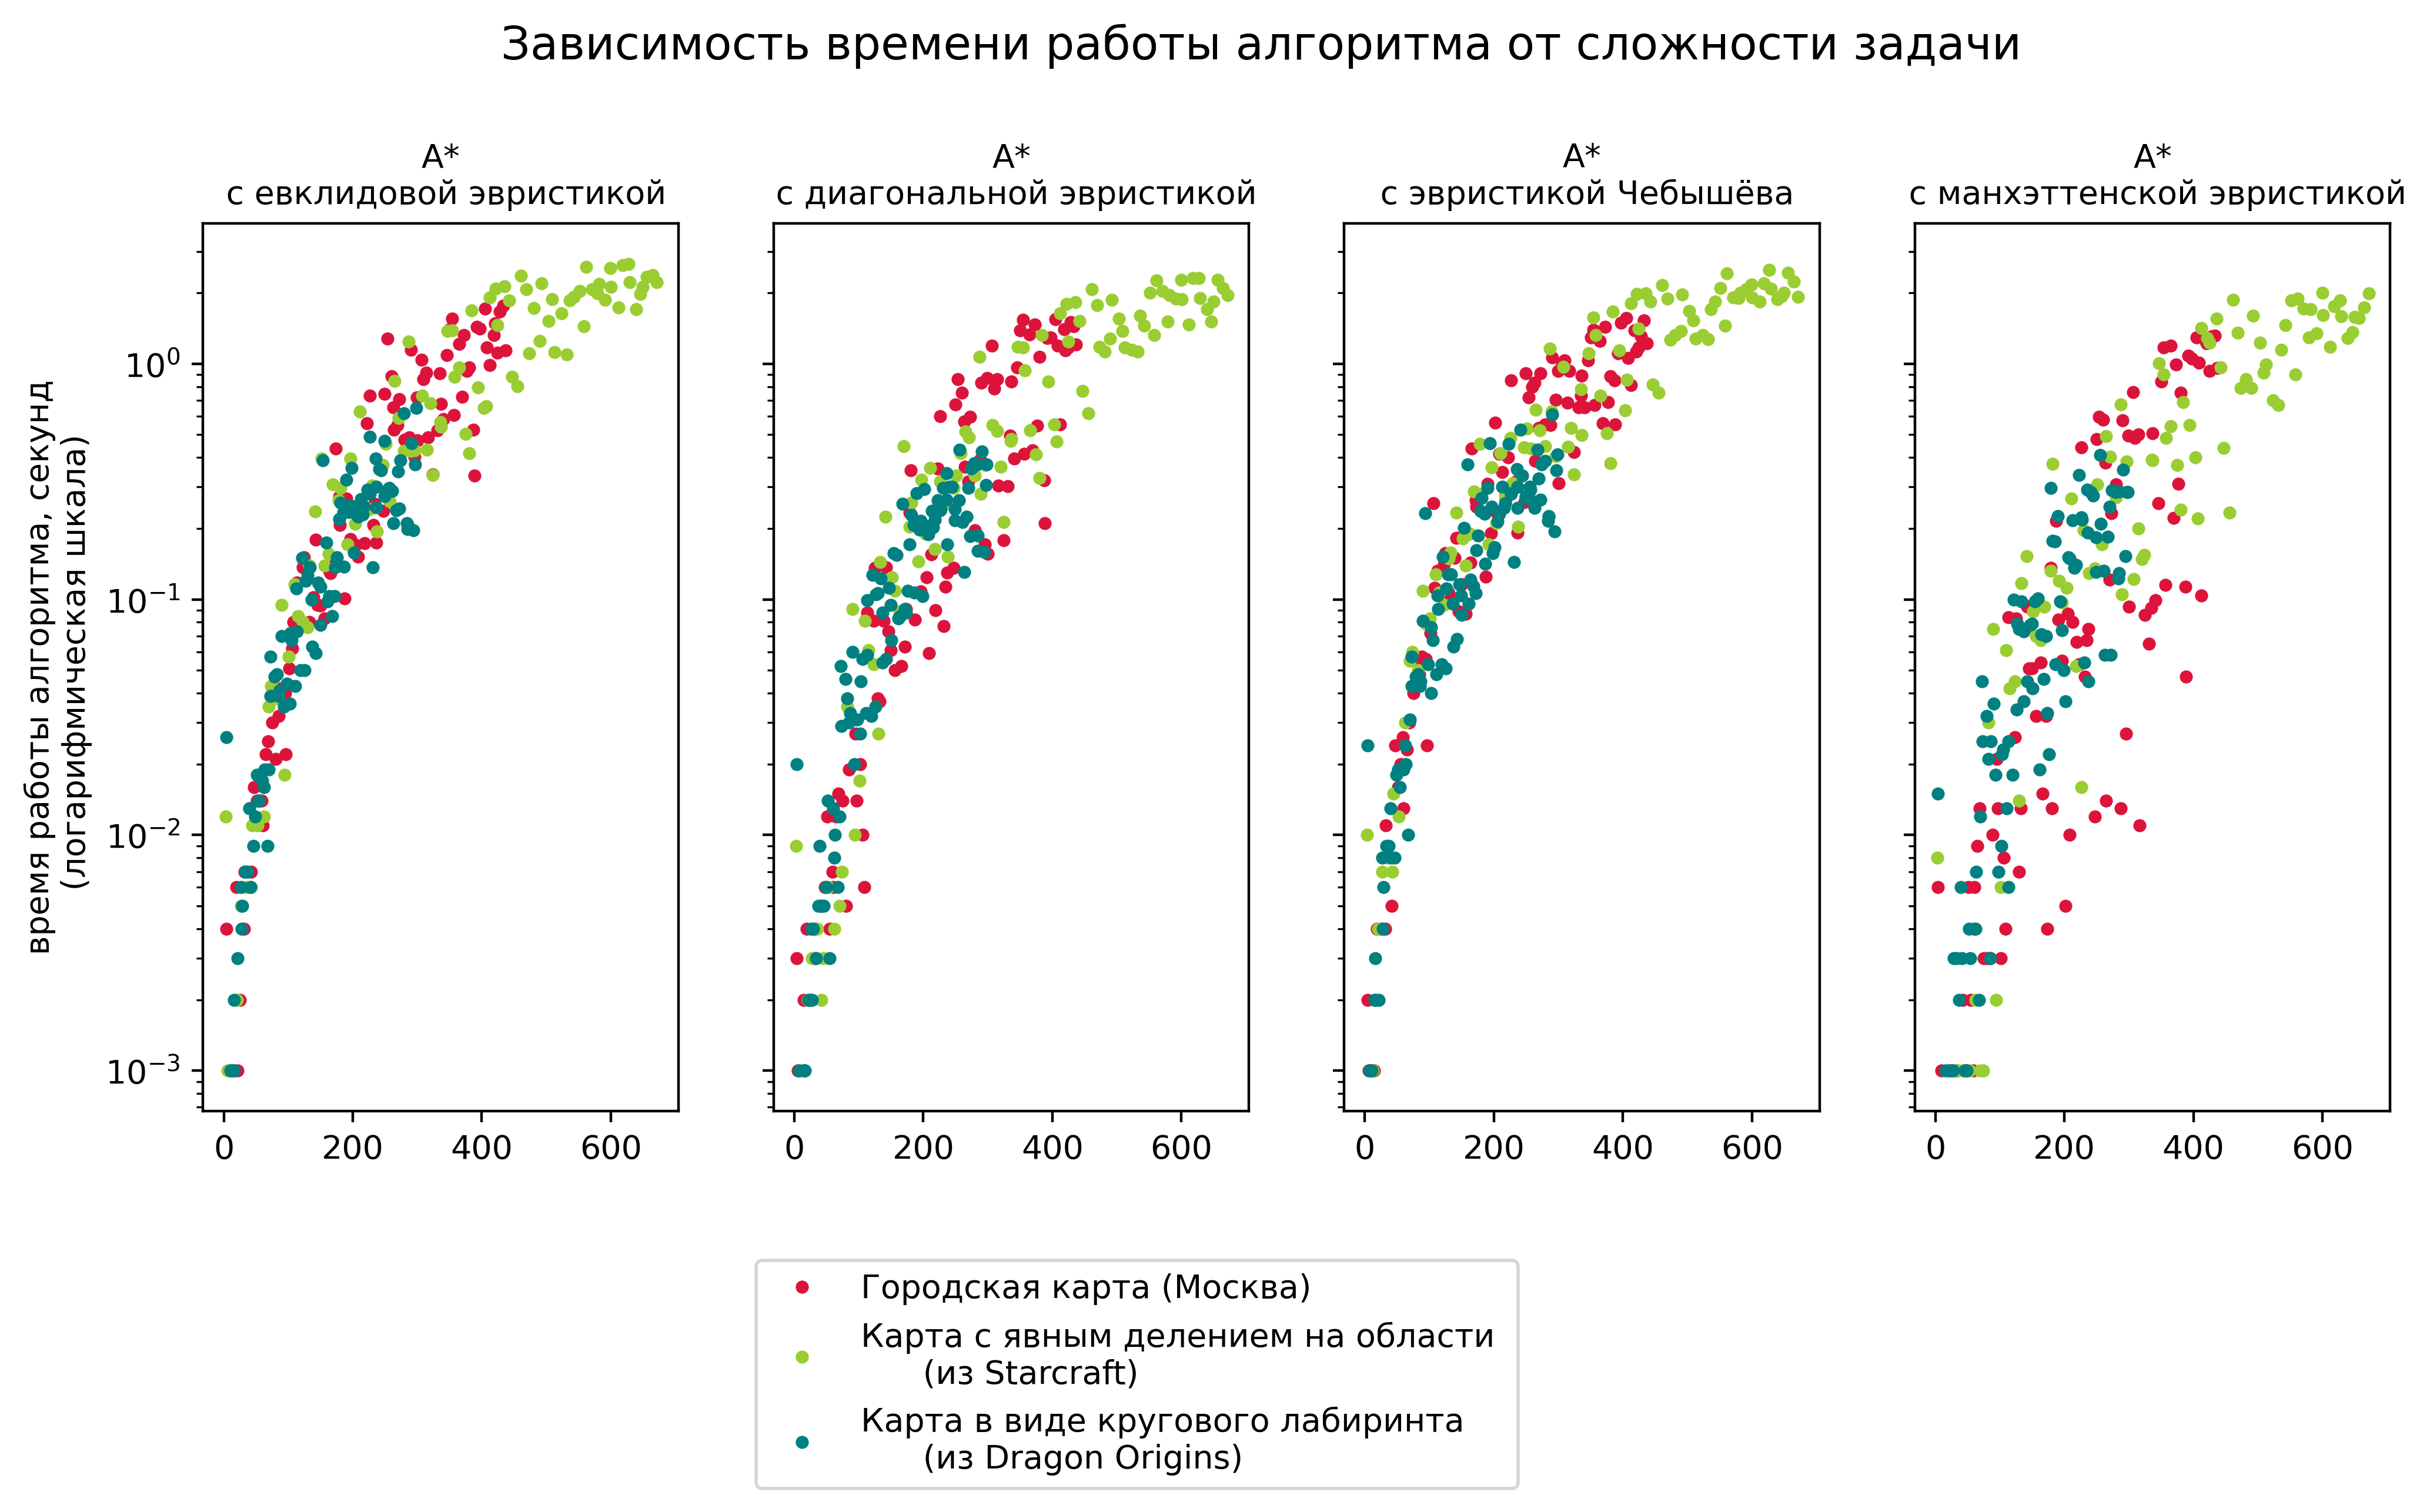

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), dpi=400, sharey=True)
fig.suptitle("Зависимость времени работы алгоритма от сложности задачи", fontsize=14, y=1.05)
ax[0].set_ylabel("время работы алгоритма, секунд\n (логарифмическая шкала)")


ax[0].set_title('A*\n с евклидовой эвристикой', fontsize=10)
ax[0].plot(np.sort(moscow_hardness), 
        eucl_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="", label="Городская карта (Москва)")
ax[0].plot(np.sort(icefloes_hardness), 
        eucl_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="", label="Карта с явным делением на области \n      (из Starcraft)")
ax[0].plot(np.sort(dragon_hardness), 
        eucl_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="", label="Карта в виде кругового лабиринта \n      (из Dragon Origins)")

ax[1].set_title('A*\n с диагональной эвристикой', fontsize=10)
ax[1].plot(np.sort(moscow_hardness), 
        octile_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[1].plot(np.sort(icefloes_hardness), 
        octile_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[1].plot(np.sort(dragon_hardness), 
        octile_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")

ax[2].set_title('A*\n с эвристикой Чебышёва', fontsize=10)
ax[2].plot(np.sort(moscow_hardness), 
        cheb_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[2].plot(np.sort(icefloes_hardness), 
        cheb_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[2].plot(np.sort(dragon_hardness), 
        cheb_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")

ax[3].set_title('A*\n с манхэттенской эвристикой', fontsize=10)
ax[3].plot(np.sort(moscow_hardness), 
        manh_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[3].plot(np.sort(icefloes_hardness), 
        manh_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[3].plot(np.sort(dragon_hardness), 
        manh_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")


plt.yscale('log')
ax[0].legend(bbox_to_anchor=(2.8, -0.15))
plt.show()

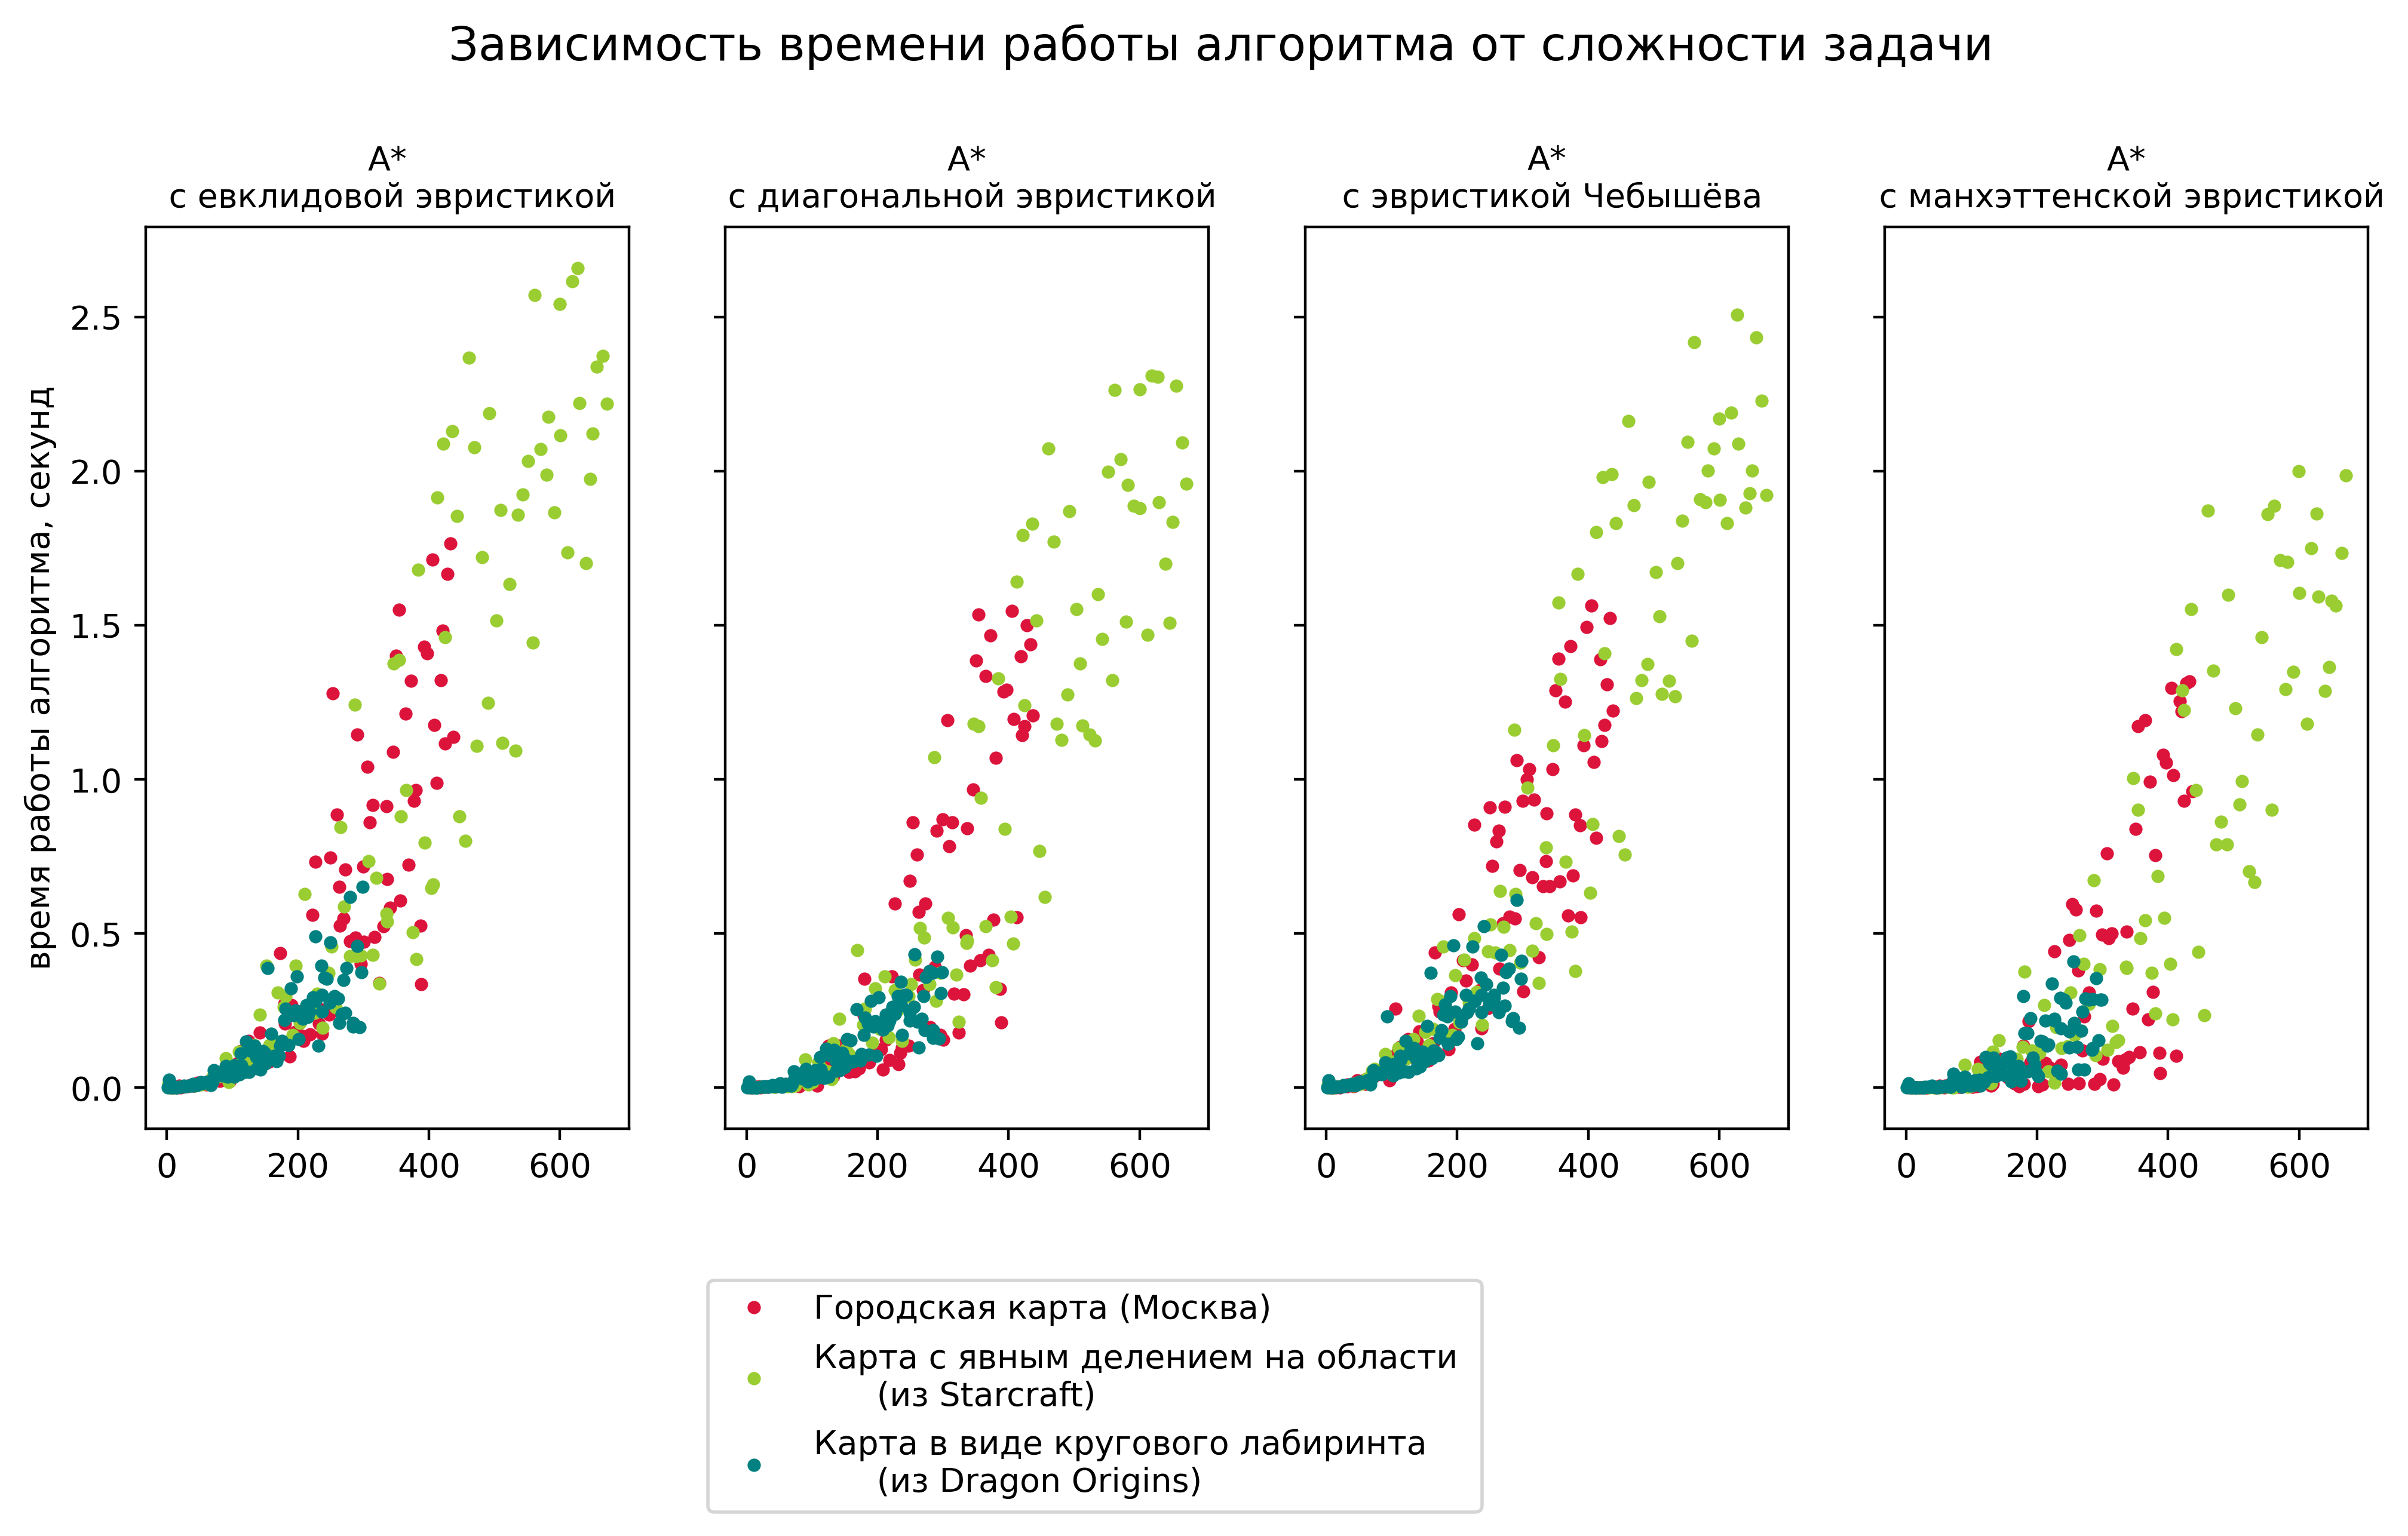

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), dpi=400, sharey=True)
fig.suptitle("Зависимость времени работы алгоритма от сложности задачи", fontsize=14, y=1.05)
ax[0].set_ylabel("время работы алгоритма, секунд")


ax[0].set_title('A*\n с евклидовой эвристикой', fontsize=10)
ax[0].plot(np.sort(moscow_hardness), 
        eucl_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="", label="Городская карта (Москва)")
ax[0].plot(np.sort(icefloes_hardness), 
        eucl_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="", label="Карта с явным делением на области \n      (из Starcraft)")
ax[0].plot(np.sort(dragon_hardness), 
        eucl_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="", label="Карта в виде кругового лабиринта \n      (из Dragon Origins)")

ax[1].set_title('A*\n с диагональной эвристикой', fontsize=10)
ax[1].plot(np.sort(moscow_hardness), 
        octile_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[1].plot(np.sort(icefloes_hardness), 
        octile_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[1].plot(np.sort(dragon_hardness), 
        octile_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")

ax[2].set_title('A*\n с эвристикой Чебышёва', fontsize=10)
ax[2].plot(np.sort(moscow_hardness), 
        cheb_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[2].plot(np.sort(icefloes_hardness), 
        cheb_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[2].plot(np.sort(dragon_hardness), 
        cheb_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")

ax[3].set_title('A*\n с манхэттенской эвристикой', fontsize=10)
ax[3].plot(np.sort(moscow_hardness), 
        manh_runtime[0][np.argsort(moscow_hardness)],
        marker='.', color="crimson", linestyle="")
ax[3].plot(np.sort(icefloes_hardness), 
        manh_runtime[1][np.argsort(icefloes_hardness)],
        marker='.', color="yellowgreen", linestyle="")
ax[3].plot(np.sort(dragon_hardness), 
        manh_runtime[2][np.argsort(dragon_hardness)],
        marker='.', color="teal", linestyle="")


ax[0].legend(bbox_to_anchor=(2.8, -0.15))
plt.show()